# Mettalex Autonomous Market Maker 

Date: 2020-12-02

Author: Matt McDonnell, Fetch.ai/Mettalex 

This notebook describes the calcuations used by the initial version of the Mettalex Autonomous Market Maker (AMM) 
to provide fair liquidity-sensitive pricing.  

Currently the [Mettalex system](https://www.mettalex.com/read) is running on the Ethereum blockchain which has the benefit of allowing reuse of existing DeFi protocols at the expense of some limitations in the allowed efficient mathematical operations.  The Mettalex system roadmap plans to transition the autonomous market making functionality to the Fetch.ai network to make use of more advanced optimization techniques.  As such the functionality described here should be regarded as an intial version of the AMM that will be extended as more network capabilities become available.

The AMM makes use of a private [Balancer Smart Pool](https://bankless.substack.com/p/the-ultimate-guide-to-balancer-smart) internally to provide the functionality of swapping between coin token (USDT intially) and long or short position tokens.  The internal Balancer AMM is controlled to set prices of long and short tokens to reflect market demand and constraints on the token prices.

In [1]:
# Initial notebook setup: functions are stored in ./calc/amm_math.py 
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append(os.path.join(os.getcwd(), 'calc'))

from amm_math import (
    calc_spot_price, calc_token_balance, calc_out_given_in, calc_in_given_out, 
    set_amm_state, set_amm_state_rebalance, get_amm_spot_prices, get_amm_balance, 
    simple_swap_from_coin, simple_swap_to_coin, simulate_swaps_from_coin,
    calc_balancer_invariant, mint_redeem, deposit_withdraw, perform_action,
    plot_action, plot_action_orderbook, print_state_change, perform_action_sequence
)

import sympy as sp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

## AMM Reweighting
The [Balancer whitepaper](https://balancer.finance/whitepaper/) describes the mathematics underlying the internal Balancer pool used for swaps between coin and long or short token.  The Mettalex AMM is a three token Balancer pool consisting of the coin collateral token, long position token, and short position token.  The position token prices are subject to the following constraints:

* A pair of  long and short tokens is equal in value to the underlying coin backing the pair i.e. $1L + 1S = \$C$. 
* The long token fair value varies linearly from $0 \rightarrow \$C$ as spot price varies between floor and cap of the trading band.  The short token varies linearly from $\$C \rightarrow 0$ over the same range.

To meet these constraints the weights of the pool are updated to set the desired prices.

Below we define some symbols used to represent the pool state and solve for the weights subject to token price constraints.

In [2]:
# Weights
w_c, w_l, w_s = sp.symbols('w_c w_l w_s', positive=True)
# Token balances
x_c, x_l, x_s = sp.symbols('x_c x_l x_s', positive=True)
# Prices - in units of locked up collateral
v = sp.symbols('v', positive=True) 
# Swap fee in fraction of input tokens
s_f = sp.symbols('s_f')
# Decimal scaling 
d_c, d_p = sp.symbols('d_c d_p', positive=True)
# Collateral backing L + S 
# e.g. for $100.000_000_000_000_000_000 = 1.000_000 mt
# this is 100*10**18 / 1*10**6 = 10**14
C = sp.symbols('C', positive=True)

# Input token amounts for swaps
a_c, a_l, a_s = sp.symbols('a_c a_l a_s', positive=True)
x_m = sp.symbols('x_m')  # Amount of coin tokens used for minting long and short

The spot price of each token is dependent on the token balances and weights as shown below.

In [3]:
help(calc_spot_price)

Help on function calc_spot_price in module amm_math:

calc_spot_price(bI, wI, bO, wO, sF=0)
    calcSpotPrice                                                                             //
     sP = spotPrice                                                                            //
     bI = tokenBalanceIn                ( bI / wI )         1                                  //
     bO = tokenBalanceOut         sP =  -----------  *  ----------                             //
     wI = tokenWeightIn                 ( bO / wO )     ( 1 - sF )                             //
     wO = tokenWeightOut                                                                       //
     sF = swapFee



Constraints on the pool weights:

In [4]:
# Constraint 1: sum of weights is 1
sp.Equality(w_c + w_l + w_s, 1)

Eq(w_c + w_l + w_s, 1)

In [5]:
# Constraint 2: Long token price is v*C, C is underlying collateral of pair
sp.Equality(calc_spot_price(x_c, w_c, x_l, w_l, 0), v*C)

Eq(w_l*x_c/(w_c*x_l), C*v)

In [6]:
# Constraint 3: Short token price is (1-v)*C, C is underlying collateral of pair
sp.Equality(calc_spot_price(x_c, w_c, x_s, w_s, 0), (1-v)*C)

Eq(w_s*x_c/(w_c*x_s), C*(1 - v))

Given the above constraints and a spot price that is fraction $v$ from the floor of the trading range we can solve for the pool weights for arbitrary token balances in the pool, as shown below.

In [7]:
sol = sp.solve(
    [w_c + w_l + w_s - 1,   # Weights sum to 1
     calc_spot_price(x_c, w_c, x_l, w_l, 0) - v*C,      # Long token price = v*C
     calc_spot_price(x_c, w_c, x_s, w_s, 0) - (1-v)*C,  # Short token price = (1-v)*C
     # Is there another constraint we can add e.g. gradient so that x_m d.o.f. is useful?
    ]
     , [w_c, w_l, w_s])

In [8]:
sp.Equality(w_c, sol[w_c])

Eq(w_c, x_c/(C*v*x_l - C*x_s*(v - 1) + x_c))

In [9]:
sp.Equality(w_l, sol[w_l])

Eq(w_l, C*v*x_l/(C*v*x_l - C*x_s*(v - 1) + x_c))

In [10]:
sp.Equality(w_s, sol[w_s])

Eq(w_s, -C*x_s*(v - 1)/(C*v*x_l - C*x_s*(v - 1) + x_c))

In [11]:
# Full set of weights needed to set the spot prices of long and short tokens
# This is the underlying math used in StrategyBalancerMettalex Solidity code.
sol

{w_c: x_c/(C*v*x_l - C*x_s*(v - 1) + x_c),
 w_l: C*v*x_l/(C*v*x_l - C*x_s*(v - 1) + x_c),
 w_s: -C*x_s*(v - 1)/(C*v*x_l - C*x_s*(v - 1) + x_c)}

### AMM Rebalancing
Alternatively, we can adjust the token prices by changing the number of coin, long, and short operations via mint or redeem operations using the Mettalex vault.  However minting or redeeming alone only provides a single degree of freedom so in general it is only possible to match one of the desired token prices at a time.

More investigation is needed on how to use minting/redeeming during price updates.

In [12]:
sol2_long = sp.solve(
    [ # w_c + w_l + w_s - 1,   # Weights sum to 1
        # Use x_m coin to mint x_m/C long and short tokens
     calc_spot_price(x_c - x_m, w_c, x_l + x_m/C, w_l, 0) - v*C, # Long token price = v*C
     # calc_spot_price(x_c - x_m, w_c, x_s + x_m/C, w_s, 0) - (1-v)*C,  # Short token price = (1-v)*C
    ]
     , [x_m]) 

In [13]:
# Long token price
sp.simplify(calc_spot_price(x_c - x_m, w_c, x_l + x_m/C, w_l, 0).subs(sol2_long))

C*v

In [14]:
# Short token price
sp.simplify(calc_spot_price(x_c - x_m, w_c, x_s + x_m/C, w_s, 0).subs(sol2_long))

C*v*w_s*(C*x_l + x_c)/(-C*v*w_c*x_l + C*v*w_c*x_s + C*w_l*x_s + w_l*x_c)

Look at the gradient of the spot price with respect to minting tokens

In [15]:
sp.simplify(
    sp.diff(calc_spot_price(x_c - x_m, w_c, x_l + x_m/C, w_l, 0), x_m)
)

-C*w_l*(C*x_l + x_c)/(w_c*(C*x_l + x_m)**2)

In [16]:
sp.simplify(
    sp.diff(calc_spot_price(x_c - x_m, w_c, x_s + x_m/C, w_s, 0), x_m)
)

-C*w_s*(C*x_s + x_c)/(w_c*(C*x_s + x_m)**2)

Thoughts:
* both long and short token prices decrease the more that are minted.  This is a bit unexpected but makes sense if price increase due to amount of coin decreasing is slower than price decrease due to amount of position tokens increasing.
* in the $x_m << Cx_s, Cx_l$ limit we can approximate the price change as being linear in $x_m$ and solve for amount to mint/redeem to achieve sum of spot prices constraint

# Working with AMM State
We now look at the state of the AMM after performing operations such as swapping from C to L or vice versa.

In [17]:
help(set_amm_state)

Help on function set_amm_state in module amm_math:

set_amm_state(x_c, x_l, x_s, v, C, sF=0)
    For fixed token balances calculate the weights needed to achieve
    L price = v*C, S price = (1-v)*C where C is the coin needed to mint 1 L + 1 S



In [18]:
# Check that we get the correct price 
get_amm_spot_prices(
    set_amm_state(
        10000,   # $10 000
        100,     # 100 L
        100,     # 100 S
        0.5, 100    # L price is 0.5*$100
    )
)

[50.0000000000000, 50.0000000000000]

In [19]:
# Note that we don't need to have the same number of tokens to achieve equal L and S price
# as the weights can achieve any price
get_amm_spot_prices(
    set_amm_state(
        10000,   # $10 000
        100,     # 100 L
        10,      # 10 S
        0.5, 100    # L price is 0.5*$100
    )
)

[50.0000000000000, 50.0000000000000]

# Pool balance
What is the value of the assets in the pool?  
* A conservative option is to count only coin and paired tokens in which case value is $x_c + \min(x_l, x_s)*C$.  
* A less conservative option uses the spot price of all assets in pool in which case value is $x_c + x_l*v_l*C + x_s*v_s*C$ where the current spot price fractions $v_p, v_s$ reflect the pool spot price taking into account position imbalances i.e. $v_p = \frac{x_c}{x_l}\frac{w_l}{w_c}/C$ etc.

Use the latter value function for the moment and see how we can rebalance the pool after swap to keep the value constant.

## Trading - simple swaps 
When we trade with the pool without reweighting, or using the Mettalex vault to mint and redeem tokens, we see arbitrage opportunities being created when $1L + 1S != \$C$.

In [20]:
print_state_change('swap_from_coin', set_amm_state(10000, 100, 100, 0.5, 100), 500)

Action: swap_from_coin
Tokens in: 500.00  Tokens out: 9.30  Average Price: 53.78
Old balance 20000.00: 10000.00 Coin  100.00 Long  100.00  Short
New balance 21000.00: 10500.00 Coin  90.70 Long  100.00  Short
Old spot prices: Long 50.00  Short 50.00
New spot prices: Long 57.88  Short 52.50



([10500,
  90.7029478458050,
  100,
  0.500000000000000,
  0.250000000000000,
  0.250000000000000],
 9.29705215419502,
 53.7804878048780)

In [21]:
print_state_change('swap_to_coin', set_amm_state(10000, 100, 100, 0.5, 100), 10)

Action: swap_to_coin
Tokens in: 10.00  Tokens out: 465.37  Average Price: 46.54
Old balance 20000.00: 10000.00 Coin  100.00 Long  100.00  Short
New balance 19069.25: 9534.63 Coin  110.00 Long  100.00  Short
Old spot prices: Long 50.00  Short 50.00
New spot prices: Long 43.34  Short 47.67



([9534.62589245592,
  110,
  100,
  0.500000000000000,
  0.250000000000000,
  0.250000000000000],
 465.374107544076,
 46.5374107544076)

To avoid this arbitrage opportunity we can reweight the pool after each swap so that $1L + 1S = \$C$

In [22]:
print_state_change(
    'swap_from_coin', set_amm_state(10000, 100, 100, 0.5, 100), 500, 
    rebalance=True, coin_per_pair=100
)

Action: swap_from_coin
Tokens in: 500.00  Tokens out: 9.30  Average Price: 53.78
Old balance 20000.00: 10000.00 Coin  100.00 Long  100.00  Short
New balance 20012.49: 10500.00 Coin  90.70 Long  100.00  Short
Old spot prices: Long 50.00  Short 50.00
New spot prices: Long 52.44  Short 47.56



([10500,
  90.7029478458050,
  100,
  0.524672469623600,
  0.237663765188200,
  0.237663765188200],
 9.29705215419502,
 53.7804878048780)

In [23]:
print_state_change(
    'swap_to_coin', set_amm_state(10000, 100, 100, 0.5, 100), 10,
    rebalance=True, coin_per_pair=100
)

Action: swap_to_coin
Tokens in: 10.00  Tokens out: 465.37  Average Price: 46.54
Old balance 20000.00: 10000.00 Coin  100.00 Long  100.00  Short
New balance 20010.82: 9534.63 Coin  110.00 Long  100.00  Short
Old spot prices: Long 50.00  Short 50.00
New spot prices: Long 47.62  Short 52.38



([9534.62589245592,
  110,
  100,
  0.476473608912582,
  0.261763195543709,
  0.261763195543709],
 465.374107544076,
 46.5374107544076)

### Price impact for purchasing position tokens with no reweight
We show below the new long and short token prices after a swap of coin for long tokens, without rewighting the pool.  It can be seen that the price of both long and short tokens increase since the amount of coin in the pool has increased.  The long token spot price increases more becuase long tokens have been removed from the pool.

In [24]:
# Price impact for range of long token purchases
initial_state = set_amm_state(10000, 100, 100, 0.5, 100)
coin_in = np.linspace(1., 5000., 20)
states, tok_out, avg_price = zip(*[perform_action('swap_from_coin', initial_state, c) for c in coin_in])

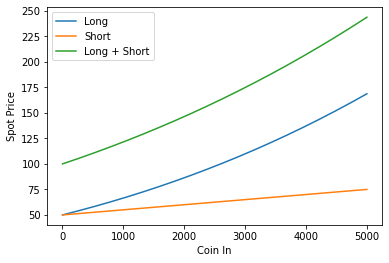

In [25]:
# Spot prices and sum
spot_prices = np.array([get_amm_spot_prices(s) for s in states])
_ = plt.plot(coin_in, spot_prices)
_ = plt.plot(coin_in, np.sum(spot_prices, axis=1))
_ = plt.legend(['Long', 'Short', 'Long + Short'])
_ = plt.xlabel('Coin In')
_ = plt.ylabel('Spot Price')

### Price impact for selling position tokens without reweighting
We see a similar effect if we swap long position tokens for coins in the pool i.e. both token prices in the pool decrease because the amount of coin in the pool decreases.

In [26]:
initial_state = set_amm_state(10000, 100, 100, 0.5, 100)
tok_in = np.linspace(1., 50., 20)
states, coin_out, avg_price = zip(*[simple_swap_to_coin(initial_state, t) for t in tok_in])

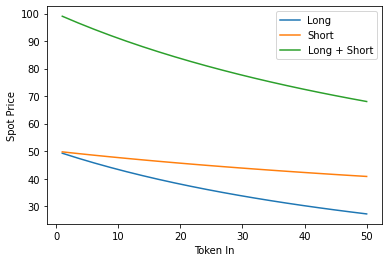

In [27]:
# Spot prices and sum
spot_prices = np.array([get_amm_spot_prices(s) for s in states])
_ = plt.plot(tok_in, spot_prices)
_ = plt.plot(tok_in, np.sum(spot_prices, axis=1))
_ = plt.legend(['Long', 'Short', 'Long + Short'])
_ = plt.xlabel('Token In')
_ = plt.ylabel('Spot Price')

## Pool Balance with and without Reweighting after swap
Below we show the effect of rebalancing the pool weights after a swap to reset the sum of long and short token prices to be equal to the value of the coin backing the pair. It can be seen that rebalancing keeps the sum of prices constant and reduces the impact of the swap on the pool balance.

In [28]:
# Price impact for range of long token purchases
initial_state = set_amm_state(10000, 100, 100, 0.5, 100)
coin_in = np.linspace(1., 5000., 20)
# With reweighting of tokens to achieve sum pf prices equal to collateral
states, tok_out, avg_price = zip(
    *[perform_action('swap_from_coin', initial_state, c, coin_per_pair=100, rebalance=True) for c in coin_in])
# No rebalancing, raw C->L (or C->S) swap
states_raw, tok_out_raw, avg_price_raw = zip(
    *[perform_action('swap_from_coin',initial_state, c, coin_per_pair=100, rebalance=False) for c in coin_in])

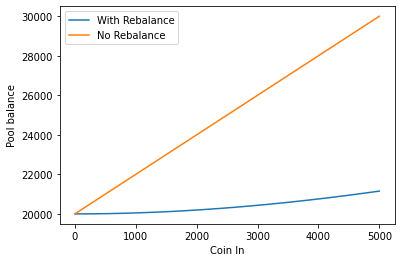

In [29]:
# Pool balance
balances = np.array([get_amm_balance(s) for s in states])
balances_raw = np.array([get_amm_balance(s) for s in states_raw])
_ = plt.plot(coin_in, balances)
_ = plt.plot(coin_in, balances_raw) # No rebalance
_ = plt.legend(['With Rebalance', 'No Rebalance'])
_ = plt.xlabel('Coin In')
_ = plt.ylabel('Pool balance')

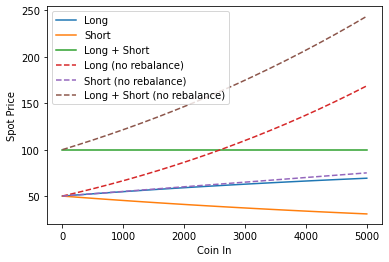

In [30]:
# Spot prices and sum
spot_prices = np.array([get_amm_spot_prices(s) for s in states])
spot_prices_raw = np.array([get_amm_spot_prices(s) for s in states_raw])

_ = plt.plot(coin_in, spot_prices)
_ = plt.plot(coin_in, np.sum(spot_prices, axis=1))
_ = plt.plot(coin_in, spot_prices_raw, linestyle='--')
_ = plt.plot(coin_in, np.sum(spot_prices_raw, axis=1), linestyle='--')
_ = plt.legend(['Long', 'Short', 'Long + Short', 
                'Long (no rebalance)', 'Short (no rebalance)', 'Long + Short (no rebalance)'])
_ = plt.xlabel('Coin In')
_ = plt.ylabel('Spot Price')

# Swap scenarios
Testing different options to swap coin for position tokens and vice versa, while avoiding arbitrage opportunities and loss of liquidity.  We focus on two key aspects:
* do the spot prices for long and short sum to the value of the undelying collateral?
* does the balance of the autonomous market maker not decrease after a swap? 

In [31]:
initial_state

[10000, 100, 100, 0.500000000000000, 0.250000000000000, 0.250000000000000]

## Check swapping position token for coin

See below for a more systematic investigation of whether a round trip of buy L from AMM, sell L back to AMM results in the AMM gaining money.  

In [32]:
help(simulate_swaps_from_coin)

Help on function simulate_swaps_from_coin in module amm_math:

simulate_swaps_from_coin(x_c_0, x_l_0, x_s_0, v, C, from_coin=True, c_max=1000, n_row=1, offset=0, f=None)



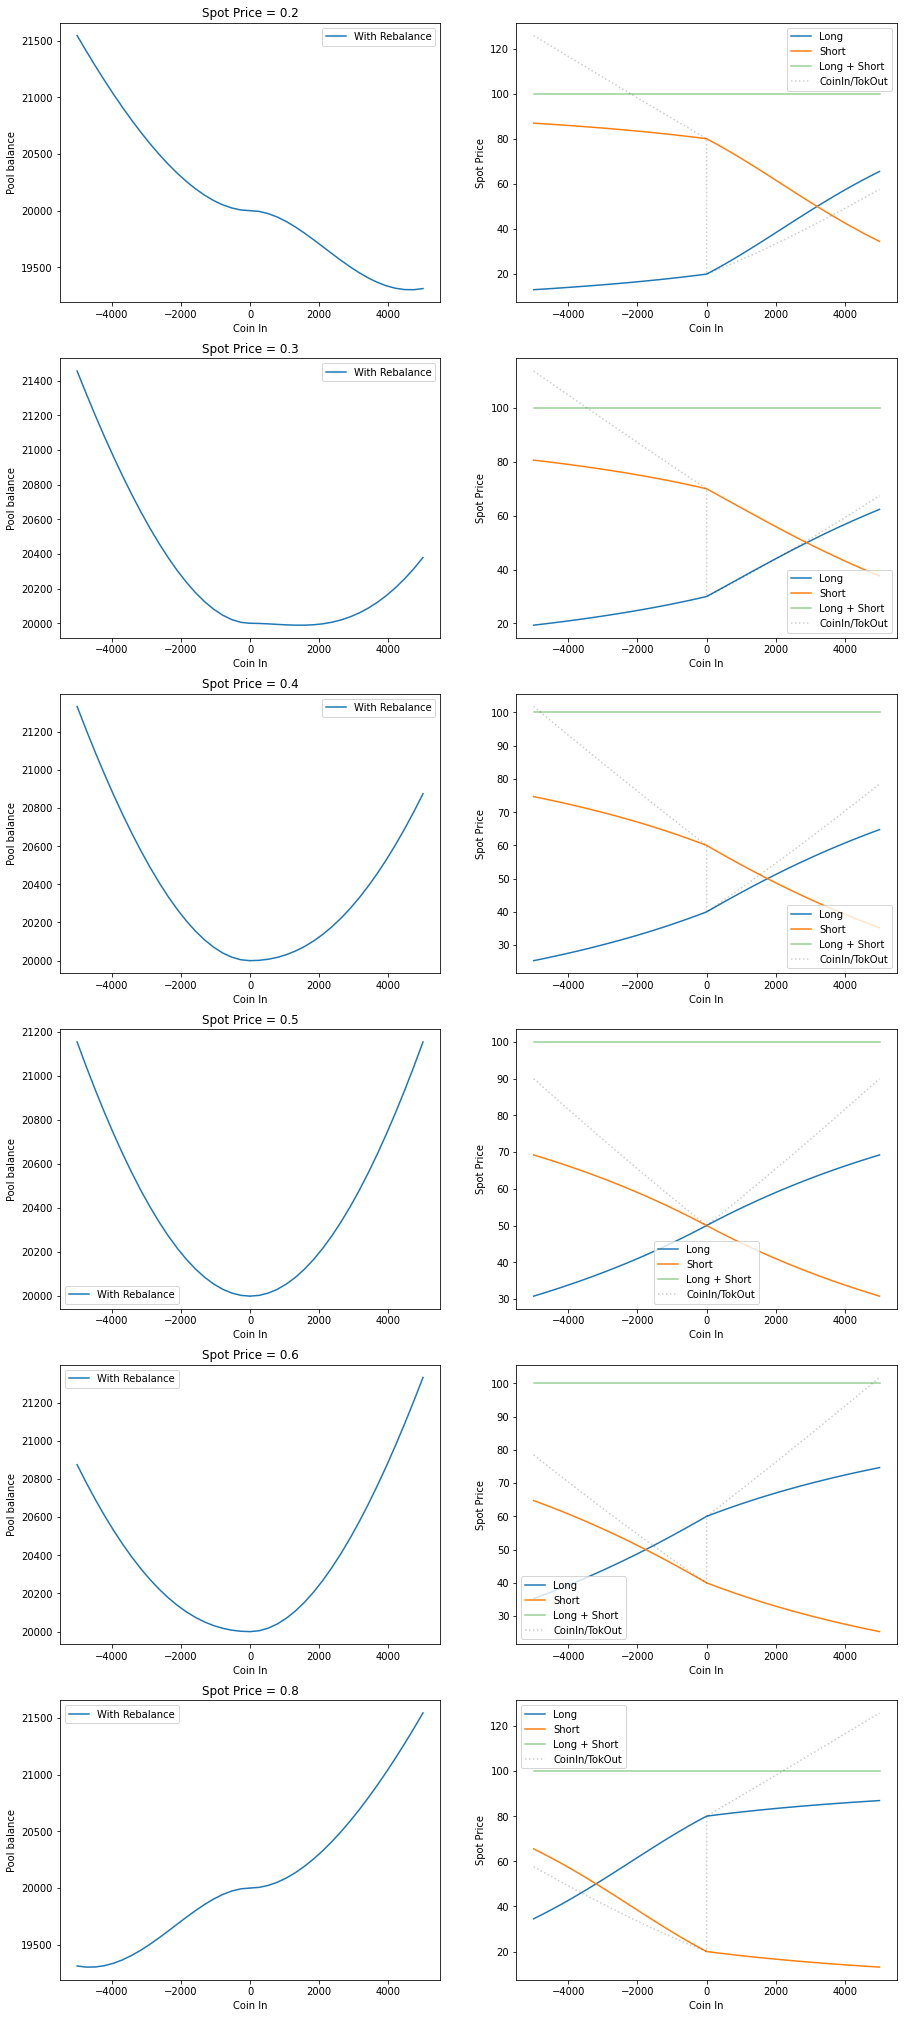

In [33]:
asset_spots = [0.2, 0.3, 0.4, 0.5, 0.6, 0.8]
n_spots = len(asset_spots)
f = plt.figure(figsize=(15, 6*n_spots))
for i, spot in enumerate(asset_spots):
    simulate_swaps_from_coin(10000, 100, 100, spot, 100, c_max=5000, n_row=n_spots, offset=i)
# f.savefig('amm_spot_prices.png')

It looks like there is a regime of spot prices where round trip swaps of long or short tokens result in the pool balance increasing, which is good for AMM liquidity providers.  

The exception appears to be when the spot price is close to the floor for long tokens (or cap for short tokens), in which case the average token price for the trade may be less than the price increase of the token due to imbalance.

The transition point between the behaviour seems to be when the gradient of the change in spot price is equal to the price impact.  More investigation is needed here.

# State Space Curves for Different Operations
We can think of the AMM operations as movements in the six-dimensional phase space defined by token balances and weights:
* mint or redeem moves the state along the line preserving total coin balance i.e. coin plus paired position tokens
* swap moves the state along the Balancer invariant
* deposit or withdraw moves the state 

The smart pool adjusts the Balancer weights and proportions of different tokens (the latter via mint/redeem operations) after swaps, liquidity supply, and price updates in order to reduce arbitrage opportunities.

Below we plot how the state moves and curves change in response to these operations.

In [34]:
initial_state

[10000, 100, 100, 0.500000000000000, 0.250000000000000, 0.250000000000000]

The diagram below shows the effect of swap coin for long token and reweight:
* long token balance moves along the initial (dotted) invariant curve
* short token balance remains unaffected
  * dashed intermediate invariant curve shows the new short token vs coin invariant before rebalancing
* pool weights are adjusted to fix price sum

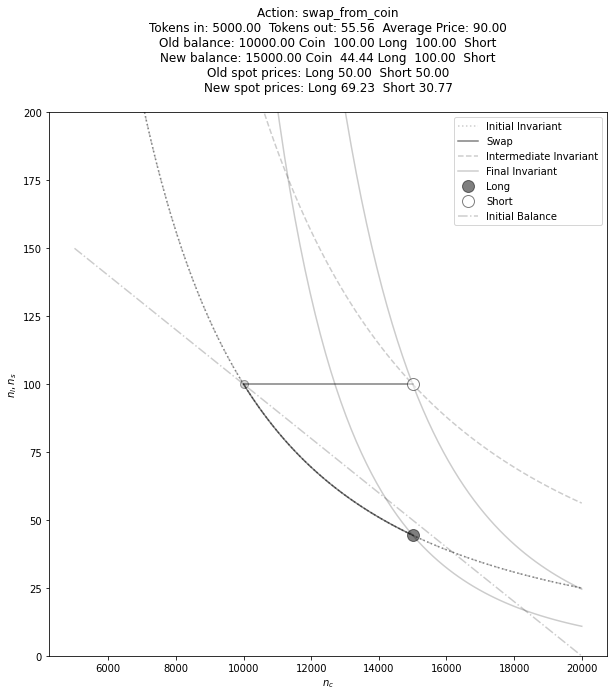

In [35]:
f = plt.figure(figsize=(10,10))
swap1_state = plot_action(
    initial_state, 5000, action='swap_from_coin', 
    rebalance=True, coin_per_pair=100, sF=0.0
)
_ = plt.ylim((0, 200))

In [36]:
print_state_change('swap_from_coin', initial_state, 5000, *swap1_state)

Action: swap_from_coin
Tokens in: 5000.00  Tokens out: 55.56  Average Price: 90.00
Old balance 20000.00: 10000.00 Coin  100.00 Long  100.00  Short
New balance 21153.85: 15000.00 Coin  44.44 Long  100.00  Short
Old spot prices: Long 50.00  Short 50.00
New spot prices: Long 69.23  Short 30.77



([15000,
  44.4444444444444,
  100,
  0.709090909090909,
  0.145454545454545,
  0.145454545454545],
 55.5555555555556,
 90.0000000000000)

We see the effect of reversing the swap by swapping the long tokens back to coin

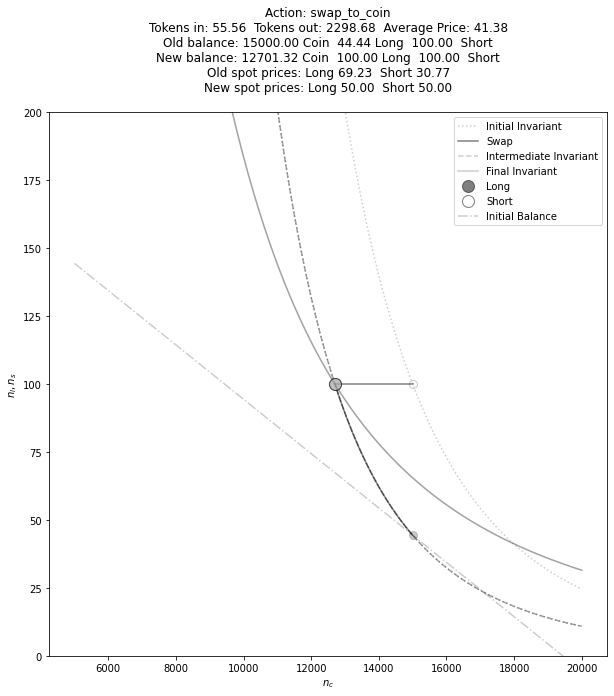

In [37]:
f = plt.figure(figsize=(10,10))
swap2_state = plot_action(
    swap1_state[0], swap1_state[1], action='swap_to_coin', 
    rebalance=True, coin_per_pair=100, sF=0.0
)
_ = plt.ylim((0, 200))

In [38]:
print_state_change('swap_to_coin', swap1_state[0], swap1_state[1], *swap2_state)

Action: swap_to_coin
Tokens in: 55.56  Tokens out: 2298.68  Average Price: 41.38
Old balance 21153.85: 15000.00 Coin  44.44 Long  100.00  Short
New balance 22701.32: 12701.32 Coin  100.00 Long  100.00  Short
Old spot prices: Long 69.23  Short 30.77
New spot prices: Long 50.00  Short 50.00



([12701.3151264306,
  100.000000000000,
  100,
  0.559496886224127,
  0.220251556887936,
  0.220251556887936],
 2298.68487356942,
 41.3763277242495)

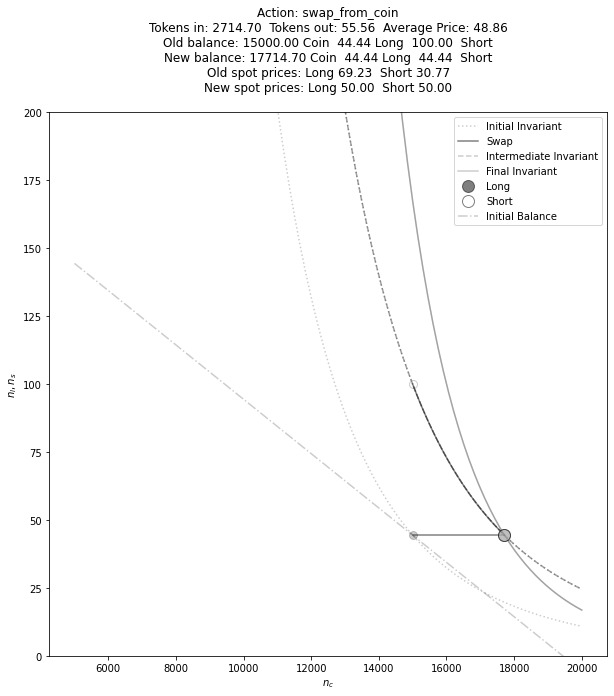

In [39]:
# Buy short equal to long bought in first swap
n_c_1, n_l_1, n_s_1, w_c_1, w_l_1, w_s_1 = swap1_state[0]
a_c_2 = calc_in_given_out(n_s_1, w_s_1, n_c_1, w_c_1, swap1_state[1])

f = plt.figure(figsize=(10,10))
swap2a_state = plot_action(swap1_state[0], a_c_2, action='swap_from_coin', rebalance=True, coin_per_pair=100, sF=0.0, to_long=False)
_ = plt.ylim((0, 200))

In [40]:
print_state_change('swap_from_coin', swap1_state[0], a_c_2, *swap2a_state)

Action: swap_from_coin
Tokens in: 2714.70  Tokens out: 55.56  Average Price: 48.86
Old balance 21153.85: 15000.00 Coin  44.44 Long  100.00  Short
New balance 22159.15: 17714.70 Coin  44.44 Long  44.44  Short
Old spot prices: Long 69.23  Short 30.77
New spot prices: Long 50.00  Short 50.00



([17714.7010179907,
  44.4444444444444,
  44.4444444444444,
  0.799430693210674,
  0.100284653394663,
  0.100284653394663],
 55.5555555555556,
 48.8646183238319)

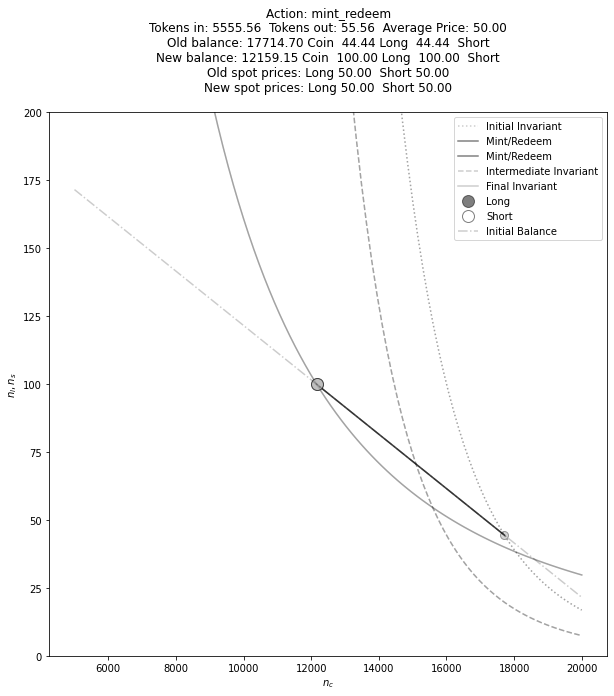

In [41]:
f = plt.figure(figsize=(10,10))
swap2b_state = plot_action(
    swap2a_state[0], 
    (initial_state[1]-swap2a_state[0][1])*100, 
    action='mint_redeem', rebalance=True, coin_per_pair=100
)
_ = plt.ylim((0, 200))

In [42]:
print_state_change('mint_redeem', swap2a_state[0], 
    (initial_state[1]-swap2a_state[0][1])*100, *swap2b_state)

Action: mint_redeem
Tokens in: 5555.56  Tokens out: 55.56  Average Price: 50.00
Old balance 22159.15: 17714.70 Coin  44.44 Long  44.44  Short
New balance 22159.15: 12159.15 Coin  100.00 Long  100.00  Short
Old spot prices: Long 50.00  Short 50.00
New spot prices: Long 50.00  Short 50.00



([12159.1454624351,
  100.000000000000,
  100.000000000000,
  0.548719059724017,
  0.225640470137992,
  0.225640470137992],
 55.5555555555556,
 50.0)

### Compare C->L, L->C

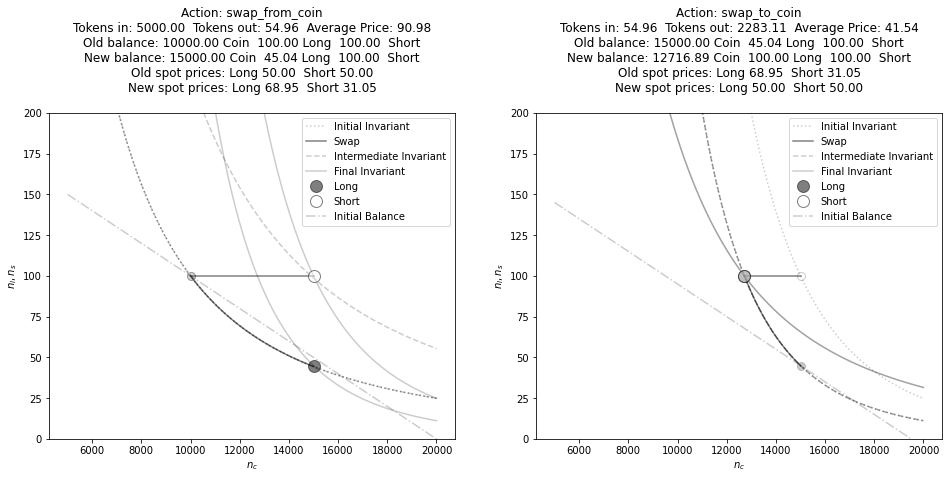

In [43]:
f = plt.figure(figsize=(16, 6))
_ = plt.subplot(1,2,1)
swap1_state = plot_action(initial_state, 5000, action='swap_from_coin', rebalance=True, coin_per_pair=100, sF=0.02)
_ = plt.ylim((0,200))

_ = plt.subplot(1,2,2)
swap2_state = plot_action(swap1_state[0], swap1_state[1], action='swap_to_coin', rebalance=True, coin_per_pair=100, sF=0.0)
_ = plt.ylim((0,200))
f.savefig('buy_long_sell_long.png', bbox_inches='tight')

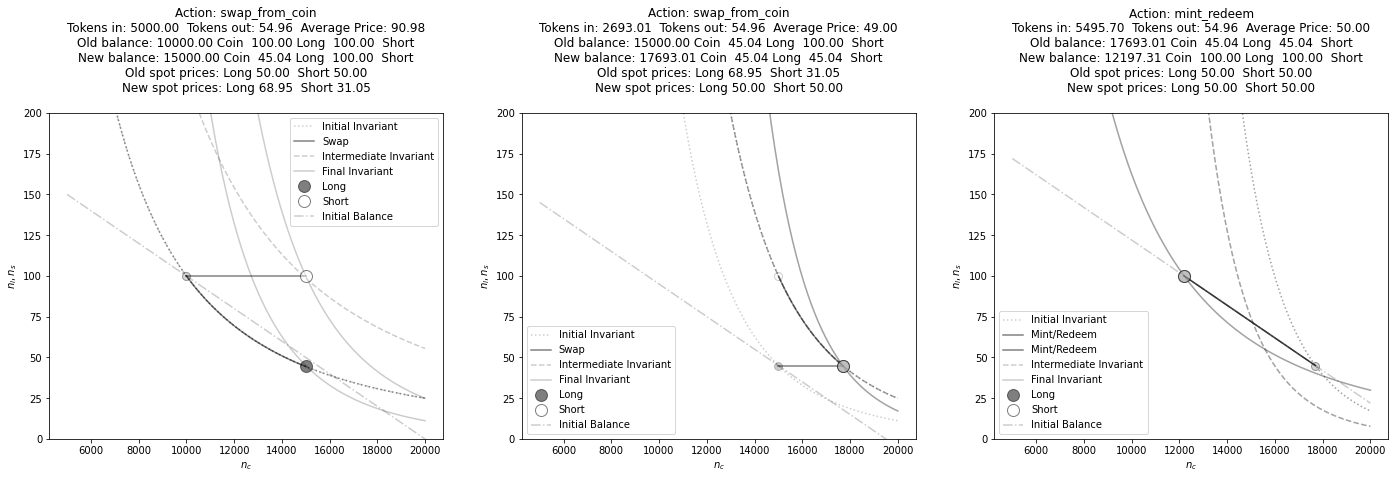

In [44]:
f = plt.figure(figsize=(24, 6))
_ = plt.subplot(1,3,1)
swap1_state = plot_action(initial_state, 5000, action='swap_from_coin', rebalance=True, coin_per_pair=100, sF=0.02)
_ = plt.ylim((0,200))

n_c_1, n_l_1, n_s_1, w_c_1, w_l_1, w_s_1 = swap1_state[0]
a_c_2 = calc_in_given_out(n_s_1, w_s_1, n_c_1, w_c_1, swap1_state[1])
_ = plt.subplot(1,3,2)
swap2a_state = plot_action(swap1_state[0], a_c_2, action='swap_from_coin', rebalance=True, coin_per_pair=100, sF=0.0, to_long=False)
_ = plt.ylim((0,200))

_ = plt.subplot(1,3,3)
swap2b_state = plot_action(
    swap2a_state[0], 
    (initial_state[1]-swap2a_state[0][1])*100, 
    action='mint_redeem', rebalance=True, coin_per_pair=100
)
_ = plt.ylim((0,200))
f.savefig('buy_long_buy_short_mint.png', bbox_inches='tight')

## Rebalancing without Reweighting
Below we investigate approaches for achieving the position token sum price constraint that do not involve reweighting:
* mint/redeem operations to move in phase space along lines of constant budget
* deposit/withdraw operations to alter the budget of the pool

It can be seen that either of these approaches can successfully achieve the sum price constraint.

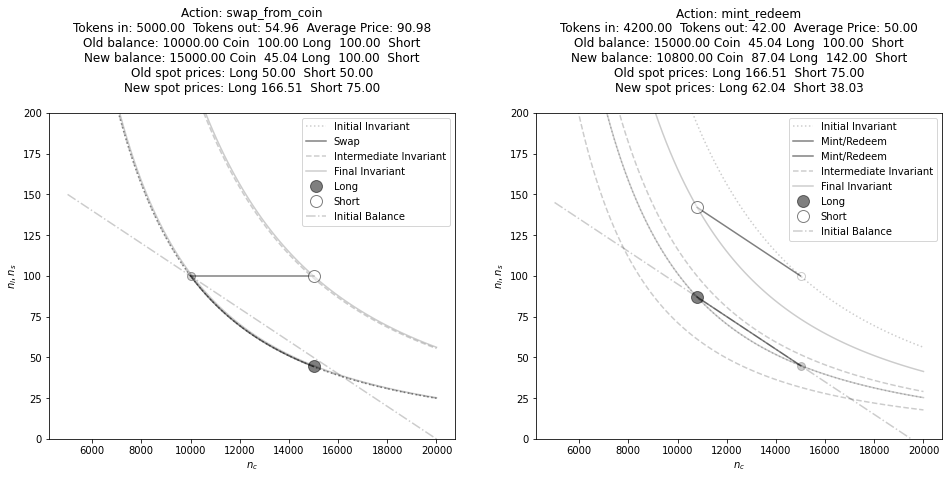

In [45]:
# Try fixing price sum with minting to change balances rather than reweighting
f = plt.figure(figsize=(16, 6))
_ = plt.subplot(1,2,1)
swap1_state = plot_action(initial_state, 5000, action='swap_from_coin', rebalance=False, coin_per_pair=100, sF=0.02)
_ = plt.ylim((0,200))

_ = plt.subplot(1,2,2)
swap2_state = plot_action(swap1_state[0], 4200, action='mint_redeem', rebalance=False, coin_per_pair=100, sF=0.0)
_ = plt.ylim((0,200))
f.savefig('buy_long_mint.png', bbox_inches='tight')


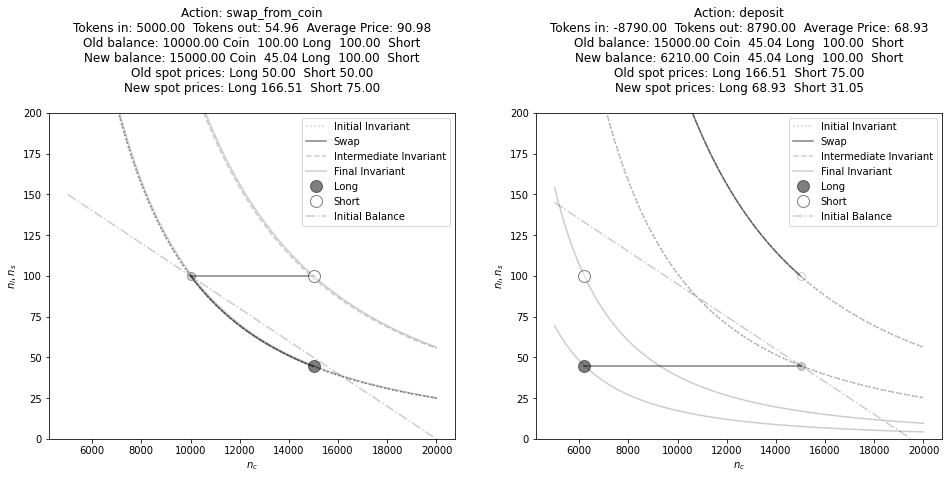

In [46]:
# Try fixing price sum with deposit/withdraw to change balances rather than reweighting
f = plt.figure(figsize=(16, 6))
_ = plt.subplot(1,2,1)
swap1_state = plot_action(initial_state, 5000, action='swap_from_coin', rebalance=False, coin_per_pair=100, sF=0.02)
_ = plt.ylim((0,200))

_ = plt.subplot(1,2,2)
swap2_state = plot_action(
    swap1_state[0], -8790, action='deposit', rebalance=False, 
    coin_per_pair=100, sF=0.0, token_fraction=0.0)
_ = plt.ylim((0,200))
f.savefig('buy_long_withdraw.png', bbox_inches='tight')


## Order Book Plots
We can plot the effective price per token for trades of different sizes being performed on AMM in a given state.  

In [47]:
swap1_state = perform_action('swap_from_coin', initial_state, 5000, rebalance=True)

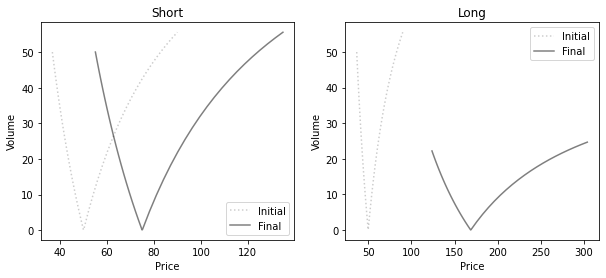

In [48]:
f = plt.figure(figsize=(10,4))
_ = plot_action_orderbook(initial_state, 5000, action='swap_from_coin', rebalance=False)

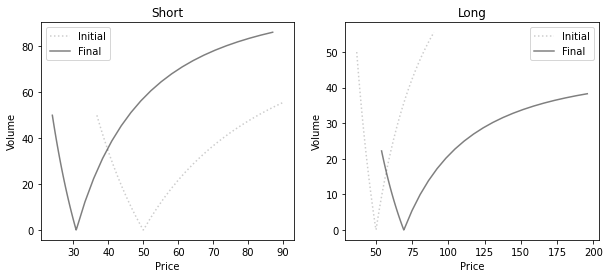

In [49]:
f = plt.figure(figsize=(10,4))
_ = plot_action_orderbook(initial_state, 5000, action='swap_from_coin', rebalance=True)

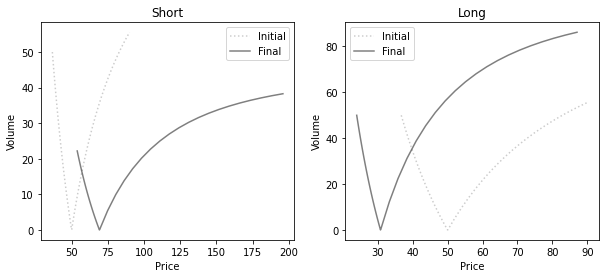

In [50]:
f = plt.figure(figsize=(10,4))
_ = plot_action_orderbook(initial_state, 5000, action='swap_from_coin', rebalance=True, to_long=False)

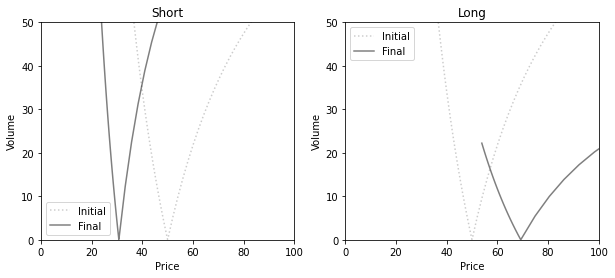

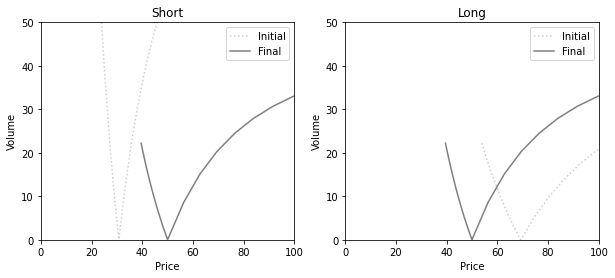

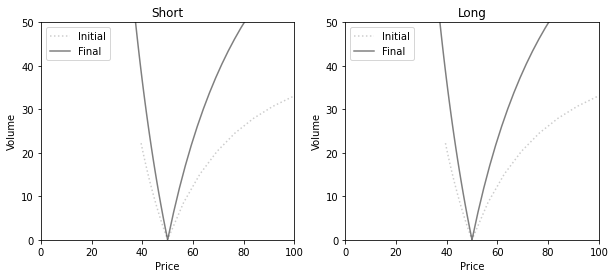

In [51]:
f = plt.figure(figsize=(10, 4))
# _ = plt.subplot(1,3,1)
swap1_state = plot_action_orderbook(
    initial_state, 5000, action='swap_from_coin', rebalance=True, coin_per_pair=100, sF=0.0,
    xlim=(0,100), ylim=(0,50)
)

n_c_1, n_l_1, n_s_1, w_c_1, w_l_1, w_s_1 = swap1_state[0]
a_c_2 = calc_in_given_out(n_s_1, w_s_1, n_c_1, w_c_1, swap1_state[1])
# _ = plt.subplot(1,3,2)
f = plt.figure(figsize=(10, 4))

swap2a_state = plot_action_orderbook(
    swap1_state[0], a_c_2, action='swap_from_coin', rebalance=True, coin_per_pair=100, sF=0.0, 
    xlim=(0,100), ylim=(0,50), to_long=False)

# _ = plt.subplot(1,3,3)
f = plt.figure(figsize=(10, 4))

swap2b_state = plot_action_orderbook(
    swap2a_state[0], 
    (initial_state[1]-swap2a_state[0][1])*100, 
    action='mint_redeem', rebalance=True, coin_per_pair=100,
    xlim=(0,100), ylim=(0,50)
)
# f.savefig('buy_long_buy_short_mint.png', bbox_inches='tight')

# Supplying Liquidity
Adding liquidity via deposit or withdrawing via withdraw needs to take into account any existing imbalance in the AMM pool and its effect on the spot price

In [52]:
initial_state

[10000, 100, 100, 0.500000000000000, 0.250000000000000, 0.250000000000000]

In [53]:
print_state_change('deposit', initial_state, 10000, coin_per_pair=100, oracle_price=50, rebalance=True, rebalance_type='amm')

Action: deposit
Tokens in: 10000.00  Tokens out: -10000.00  Average Price: 50.00
Old balance 20000.00: 10000.00 Coin  100.00 Long  100.00  Short
New balance 30000.00: 15000.00 Coin  150.00 Long  150.00  Short
Old spot prices: Long 50.00  Short 50.00
New spot prices: Long 50.00  Short 50.00



([15000.0,
  150.0,
  150.0,
  0.500000000000000,
  0.250000000000000,
  0.250000000000000],
 -10000,
 50.0000000000000)

In [54]:
state_after_swap = perform_action('swap_from_coin', initial_state, 5000, coin_per_pair=100, rebalance=True)
#deposit( state_after_swap, 10000, coin_per_pair=100, oracle_price=50, rebalance=True, rebalance_type='amm')[0]

In [55]:
state_after_swap

([15000,
  44.4444444444444,
  100,
  0.709090909090909,
  0.145454545454545,
  0.145454545454545],
 55.5555555555556,
 90.0000000000000)

In [56]:
get_amm_spot_prices(state_after_swap[0])

[69.2307692307692, 30.7692307692308]

In [57]:
get_amm_spot_prices(
    perform_action('swap_to_coin', state_after_swap[0], state_after_swap[1], coin_per_pair=100, rebalance=True)[0]
)

[49.9999999999999, 49.9999999999999]

In [58]:
get_amm_spot_prices(
    perform_action('deposit', state_after_swap[0], 10000, coin_per_pair=100, 
                   rebalance=True, oracle_price=50, rebalance_type='oracle')[0]
)

[50.0000000000000, 50.0000000000000]

In [59]:
get_amm_spot_prices(
    perform_action('deposit', state_after_swap[0], 10000, coin_per_pair=100, 
                   rebalance=True, oracle_price=50, rebalance_type='amm')[0]
)

[69.2307692307692, 30.7692307692308]

In [60]:
get_amm_spot_prices(
    perform_action('deposit', state_after_swap[0], 10000, coin_per_pair=100, 
                   rebalance=True, oracle_price=50, rebalance_type='weighted')[0]
)

[62.6995645863570, 37.3004354136430]

In [61]:
action_sequence_1 = [
    ['swap_from_coin', 5000, {'coin_per_pair': 100, 'rebalance': True}], 
    ['swap_to_coin', 55.5555, {'coin_per_pair': 100, 'rebalance': True}], 
]

In [62]:
_ = perform_action_sequence(initial_state, action_sequence_1)

[50.0000000000000, 50.0000000000000, 'initial']
[69.2307692307692, 30.7692307692308, 'swap_from_coin', 5000]
[50.0000138888927, 49.9999861111072, 'swap_to_coin', 55.5555]


# Deposits
Investigate how to set pool price after making a deposit if there is imbalance in the pool positions.  The desired behaviour is if the spot price is at some value and sentiment driven trades of given volume cause the AMM price to shift, then after depositing liquidity a trade of same volume in opposite direction should return to the original value.

In [63]:
def simulate_deposit(initial_state, rebalance_type, action_sequence=None):
    if action_sequence is None:
        action_sequence = [
            ['swap_from_coin', 10000, {'coin_per_pair': 100, 'rebalance': True}], 
            ['swap_to_coin', 75, {'coin_per_pair': 100, 'rebalance': True}], 
        ]
    res = perform_action_sequence(
        initial_state, 
        [
            action_sequence[0], 
            ['deposit', 100000, 
             {'coin_per_pair': 100, 'rebalance':True, 'oracle_price': 50, 'rebalance_type': rebalance_type}
            ],
            action_sequence[-1]
        ],
        reporter=print_state_change
    )
    return res

Approach 1: after deposit rebalance to the oracle reference price.

Problem: ignores any existing price shift due to sentiment imbalance

In [64]:
r = simulate_deposit(initial_state, 'oracle')
print(r[1])

[50.0000000000000, 50.0000000000000, 'initial']
Action: swap_from_coin
Tokens in: 10000.00  Tokens out: 75.00  Average Price: 133.33
Old balance 20000.00: 10000.00 Coin  100.00 Long  100.00  Short
New balance 24000.00: 20000.00 Coin  25.00 Long  100.00  Short
Old spot prices: Long 50.00  Short 50.00
New spot prices: Long 80.00  Short 20.00

Action: deposit
Tokens in: 100000.00  Tokens out: -100000.00  Average Price: 50.00
Old balance 24000.00: 20000.00 Coin  25.00 Long  100.00  Short
New balance 126250.00: 70000.00 Coin  525.00 Long  600.00  Short
Old spot prices: Long 80.00  Short 20.00
New spot prices: Long 50.00  Short 50.00

Action: swap_to_coin
Tokens in: 75.00  Tokens out: 3418.89  Average Price: 45.59
Old balance 126250.00: 70000.00 Coin  525.00 Long  600.00  Short
New balance 126581.11: 66581.11 Coin  600.00 Long  600.00  Short
Old spot prices: Long 50.00  Short 50.00
New spot prices: Long 46.67  Short 53.33

[0, 75.0000000000000, -100000, 3418.88559671942]


Approach 2: rebalance to current AMM spot price.  Takes into account sentiment.

Problem: amplifies sentiment too much

In [65]:
_ = simulate_deposit(initial_state, 'amm')

[50.0000000000000, 50.0000000000000, 'initial']
Action: swap_from_coin
Tokens in: 10000.00  Tokens out: 75.00  Average Price: 133.33
Old balance 20000.00: 10000.00 Coin  100.00 Long  100.00  Short
New balance 24000.00: 20000.00 Coin  25.00 Long  100.00  Short
Old spot prices: Long 50.00  Short 50.00
New spot prices: Long 80.00  Short 20.00

Action: deposit
Tokens in: 100000.00  Tokens out: -100000.00  Average Price: 80.00
Old balance 24000.00: 20000.00 Coin  25.00 Long  100.00  Short
New balance 124000.00: 70000.00 Coin  525.00 Long  600.00  Short
Old spot prices: Long 80.00  Short 20.00
New spot prices: Long 80.00  Short 20.00

Action: swap_to_coin
Tokens in: 75.00  Tokens out: 5389.53  Average Price: 71.86
Old balance 124000.00: 70000.00 Coin  525.00 Long  600.00  Short
New balance 124610.47: 64610.47 Coin  600.00 Long  600.00  Short
Old spot prices: Long 80.00  Short 20.00
New spot prices: Long 77.78  Short 22.22



Approach 3: weighted mix of oracle and AMM prices based on amount of existing and supplied liquidity

Not an exact solution but does appear to give closer to correct behaviour.

In [66]:
_ = simulate_deposit(initial_state, 'weighted')

[50.0000000000000, 50.0000000000000, 'initial']
Action: swap_from_coin
Tokens in: 10000.00  Tokens out: 75.00  Average Price: 133.33
Old balance 20000.00: 10000.00 Coin  100.00 Long  100.00  Short
New balance 24000.00: 20000.00 Coin  25.00 Long  100.00  Short
Old spot prices: Long 50.00  Short 50.00
New spot prices: Long 80.00  Short 20.00

Action: deposit
Tokens in: 100000.00  Tokens out: -100000.00  Average Price: 55.51
Old balance 24000.00: 20000.00 Coin  25.00 Long  100.00  Short
New balance 125836.73: 70000.00 Coin  525.00 Long  600.00  Short
Old spot prices: Long 80.00  Short 20.00
New spot prices: Long 55.51  Short 44.49

Action: swap_to_coin
Tokens in: 75.00  Tokens out: 3785.29  Average Price: 50.47
Old balance 125836.73: 70000.00 Coin  525.00 Long  600.00  Short
New balance 126214.71: 66214.71 Coin  600.00 Long  600.00  Short
Old spot prices: Long 55.51  Short 44.49
New spot prices: Long 52.19  Short 47.81



In [67]:
# Withdrawal
res = perform_action_sequence(
        initial_state, 
        [
            ['deposit', 10000, 
             {'coin_per_pair': 100, 'rebalance':True, 'oracle_price': 50, 'rebalance_type': 'weighted'}
            ],
            ['swap_from_coin', 1000, {'coin_per_pair': 100, 'rebalance': True}], 
            ['withdraw', 10000, 
             {'coin_per_pair': 100, 'rebalance':True, 'oracle_price': 96.25, 'rebalance_type': 'amm'}
            ],
            ['swap_to_coin', 18.16, {'coin_per_pair': 100, 'rebalance': True}],
        ],
        reporter=print_state_change
    )

[50.0000000000000, 50.0000000000000, 'initial']
Action: deposit
Tokens in: 10000.00  Tokens out: -10000.00  Average Price: 50.00
Old balance 20000.00: 10000.00 Coin  100.00 Long  100.00  Short
New balance 30000.00: 15000.00 Coin  150.00 Long  150.00  Short
Old spot prices: Long 50.00  Short 50.00
New spot prices: Long 50.00  Short 50.00

Action: swap_from_coin
Tokens in: 1000.00  Tokens out: 18.16  Average Price: 55.05
Old balance 30000.00: 15000.00 Coin  150.00 Long  150.00  Short
New balance 30033.26: 16000.00 Coin  131.84 Long  150.00  Short
Old spot prices: Long 50.00  Short 50.00
New spot prices: Long 53.22  Short 46.78

Action: withdraw
Tokens in: 10000.00  Tokens out: 10000.00  Average Price: 53.22
Old balance 30033.26: 16000.00 Coin  131.84 Long  150.00  Short
New balance 20033.26: 11000.00 Coin  81.84 Long  100.00  Short
Old spot prices: Long 53.22  Short 46.78
New spot prices: Long 53.22  Short 46.78

Action: swap_to_coin
Tokens in: 18.16  Tokens out: 839.16  Average Price: 4

In [68]:
res[0]

[[10000, 100, 100, 0.500000000000000, 0.250000000000000, 0.250000000000000],
 [15000.0,
  150.0,
  150.0,
  0.500000000000000,
  0.250000000000000,
  0.250000000000000],
 [16000.0,
  131.835937500000,
  150.0,
  0.532742627717015,
  0.233628686141492,
  0.233628686141493],
 [11000.0,
  81.8359375000000,
  100.0,
  0.549086757990867,
  0.217413864674139,
  0.233499377334994],
 [10160.8350896176,
  99.9959375000000,
  100.0,
  0.503993697098883,
  0.239156088510436,
  0.256850214390681]]

In [69]:
res[1]

[0, -10000, 18.1640625000000, 10000, 839.164910382395]

# Circuits of Swaps
Look at price impact after trade of given size then reverse trade vs trade other side

In [70]:
_ = perform_action_sequence(
        initial_state, 
        [
            ['swap_from_coin', 5000, {'coin_per_pair': 100, 'rebalance': True}], 
        ],
        reporter=print_state_change
    )

[50.0000000000000, 50.0000000000000, 'initial']
Action: swap_from_coin
Tokens in: 5000.00  Tokens out: 55.56  Average Price: 90.00
Old balance 20000.00: 10000.00 Coin  100.00 Long  100.00  Short
New balance 21153.85: 15000.00 Coin  44.44 Long  100.00  Short
Old spot prices: Long 50.00  Short 50.00
New spot prices: Long 69.23  Short 30.77



In [71]:
_ = perform_action_sequence(
        initial_state, 
        [
            ['swap_from_coin', 5000, {'coin_per_pair': 100, 'rebalance': True}], 
            ['swap_to_coin', 55.555, {'coin_per_pair': 100, 'rebalance': True}],
        ],
        reporter=print_state_change
)

[50.0000000000000, 50.0000000000000, 'initial']
Action: swap_from_coin
Tokens in: 5000.00  Tokens out: 55.56  Average Price: 90.00
Old balance 20000.00: 10000.00 Coin  100.00 Long  100.00  Short
New balance 21153.85: 15000.00 Coin  44.44 Long  100.00  Short
Old spot prices: Long 50.00  Short 50.00
New spot prices: Long 69.23  Short 30.77

Action: swap_to_coin
Tokens in: 55.55  Tokens out: 2298.67  Average Price: 41.38
Old balance 21153.85: 15000.00 Coin  44.44 Long  100.00  Short
New balance 22701.30: 12701.33 Coin  100.00 Long  100.00  Short
Old spot prices: Long 69.23  Short 30.77
New spot prices: Long 50.00  Short 50.00



In [72]:
_ = perform_action_sequence(
        initial_state, 
        [
            ['swap_from_coin', 5000, {'coin_per_pair': 100, 'rebalance': True}], 
            ['swap_from_coin', 2715, {'coin_per_pair': 100, 'rebalance': True, 'to_long': False}],
            ['mint_redeem', 5550, {'coin_per_pair':100, 'rebalance': True}]
        ],
        reporter=print_state_change
    )

[50.0000000000000, 50.0000000000000, 'initial']
Action: swap_from_coin
Tokens in: 5000.00  Tokens out: 55.56  Average Price: 90.00
Old balance 20000.00: 10000.00 Coin  100.00 Long  100.00  Short
New balance 21153.85: 15000.00 Coin  44.44 Long  100.00  Short
Old spot prices: Long 50.00  Short 50.00
New spot prices: Long 69.23  Short 30.77

Action: swap_from_coin
Tokens in: 2715.00  Tokens out: 55.56  Average Price: 48.87
Old balance 21153.85: 15000.00 Coin  44.44 Long  100.00  Short
New balance 22159.26: 17715.00 Coin  44.44 Long  44.44  Short
Old spot prices: Long 69.23  Short 30.77
New spot prices: Long 50.00  Short 50.00

Action: mint_redeem
Tokens in: 5550.00  Tokens out: 55.50  Average Price: 50.00
Old balance 22159.26: 17715.00 Coin  44.44 Long  44.44  Short
New balance 22159.26: 12165.00 Coin  99.94 Long  99.94  Short
Old spot prices: Long 50.00  Short 50.00
New spot prices: Long 50.00  Short 50.00



# State Space Swap Plots
Below we show the effect of buying $5000 worth of Long tokens from an AMM initially containing $10000, 100L, 100S, for different prices.  We see that the impact on the AMM tokens held is highest for low initial Long prices.

The dash-dot line shows the mint/redeem line from initial balance.

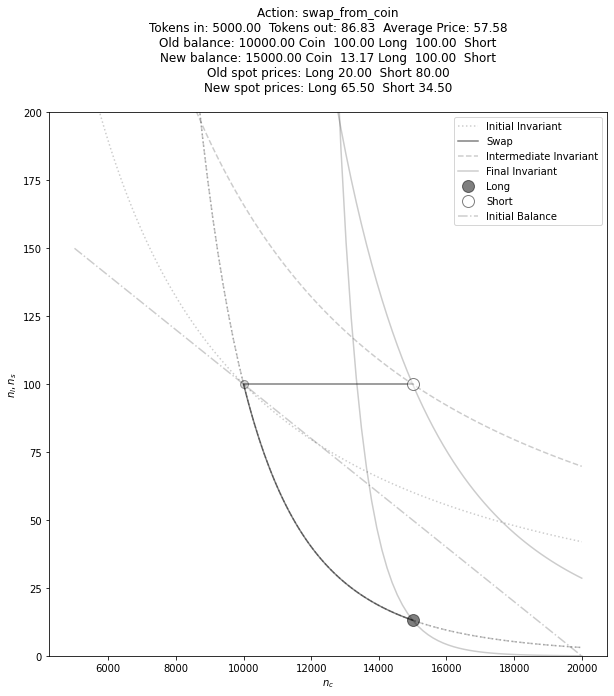

In [73]:
f = plt.figure(figsize=(10,10))
swap1_state = plot_action(
    set_amm_state(10000, 100, 100, 0.2, 100), 5000, action='swap_from_coin', 
    rebalance=True, coin_per_pair=100, sF=0.0
)
_ = plt.ylim((0, 200))

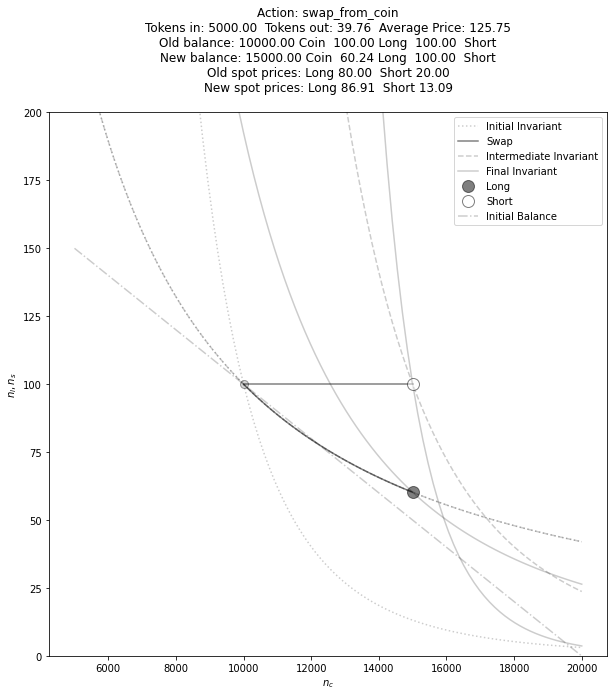

In [74]:
f = plt.figure(figsize=(10,10))
swap1_state = plot_action(
    set_amm_state(10000, 100, 100, 0.8, 100), 5000, action='swap_from_coin', 
    rebalance=True, coin_per_pair=100, sF=0.0
)
_ = plt.ylim((0, 200))

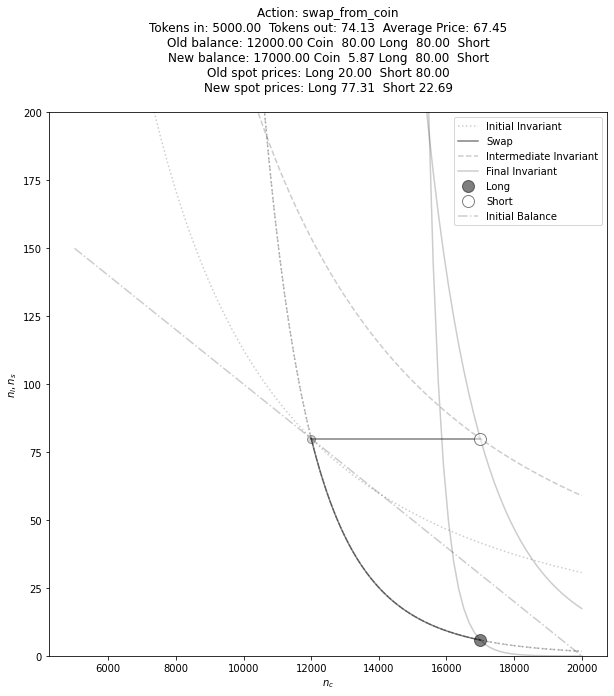

In [75]:
f = plt.figure(figsize=(10,10))
swap1_state = plot_action(
    set_amm_state(12000, 80, 80, 0.2, 100), 5000, action='swap_from_coin', 
    rebalance=True, coin_per_pair=100, sF=0.0
)
_ = plt.ylim((0, 200))

# Normalized State Space Paths
The line $x_c = x_0 - Cx_m$ represents the AMM balance being unchanged from initial balance $x_0$ as $x_m$ long and short token pairs are minted.  Note that here we use the more conservative balance measure $x_c + \min(x_l, x_s)*C$.  

We can hence subtract this balance line from the position token balances in order to obtain a plot showing the impact of swaps and other actions directly on the AMM balance.

Position token balance normalized by subtracting the initial mint/redeem line shows the impact on the AMM balance (distance the swap curve goes below the line).  For the second plot we create enough price impact that the AMM gains money just on the swap

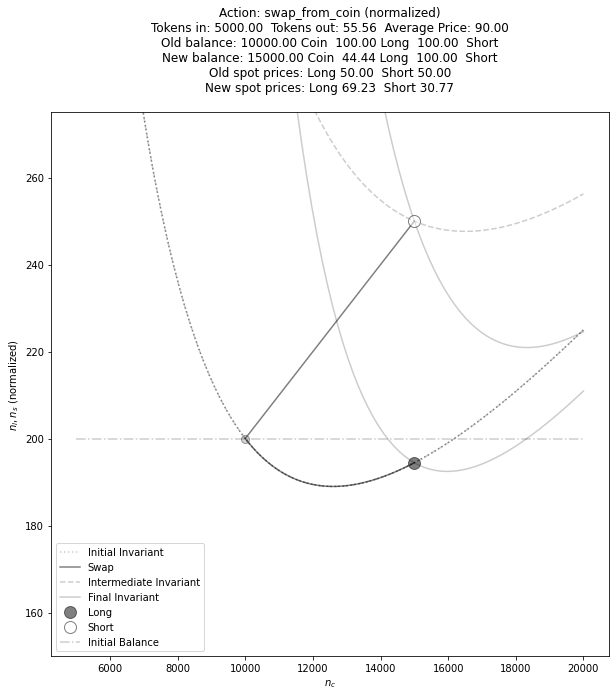

In [76]:
f = plt.figure(figsize=(10,10))
swap1_state = plot_action(
    set_amm_state(10000, 100, 100, 0.5, 100), 5000, action='swap_from_coin', 
    rebalance=True, coin_per_pair=100, sF=0.0, normalize_y=True
)
_ = plt.ylim((150, 275)) # (-25, 75))
f.savefig('/home/mattmcd/Work/swap_50_norm.png', bbox_inches='tight')

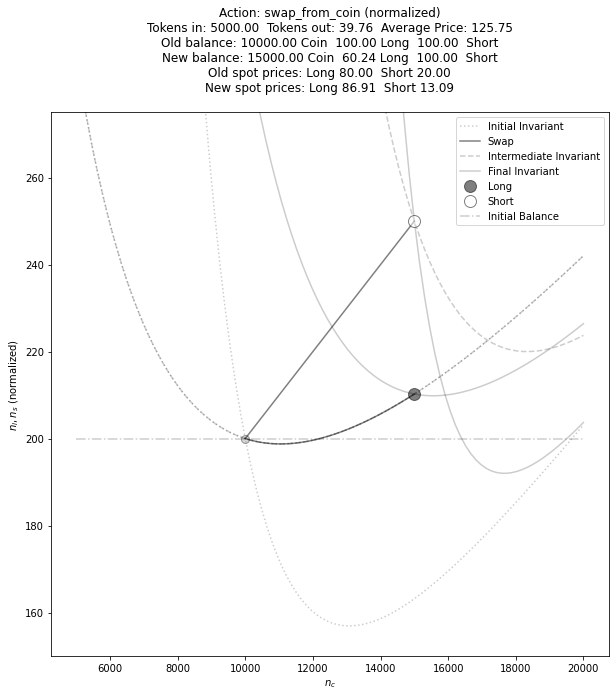

In [82]:
f = plt.figure(figsize=(10,10))
swap1_state = plot_action(
    set_amm_state(10000, 100, 100, 0.8, 100), 5000, action='swap_from_coin', 
    rebalance=True, coin_per_pair=100, sF=0.0, normalize_y=True
)
_ = plt.ylim((150, 275)) 
f.savefig(os.path.expanduser('~/Work/swap_80_norm.png'), bbox_inches='tight')

Interesting thing happens when the price is close to the floor and we buy a lot of L: the AMM suffers a large amount of impermanent loss!  In the second plot we keep the same initial balance but decrease the relative amount of position tokens, this reduces the price impact

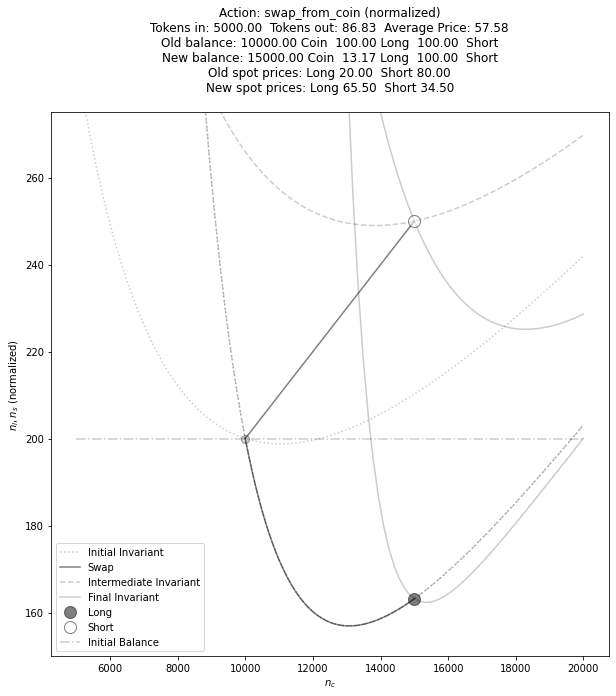

In [81]:
# Buying large amount of L tokens when asset is close to floor results in large impermanent loss
f = plt.figure(figsize=(10,10))
swap1_state = plot_action(
    set_amm_state(10000, 100, 100, 0.2, 100), 5000, action='swap_from_coin', 
    rebalance=True, coin_per_pair=100, sF=0.0, normalize_y=True
)
_ = plt.ylim((150, 275)) 
f.savefig(os.path.expanduser('~/Work/swap_20_norm.png'), bbox_inches='tight')

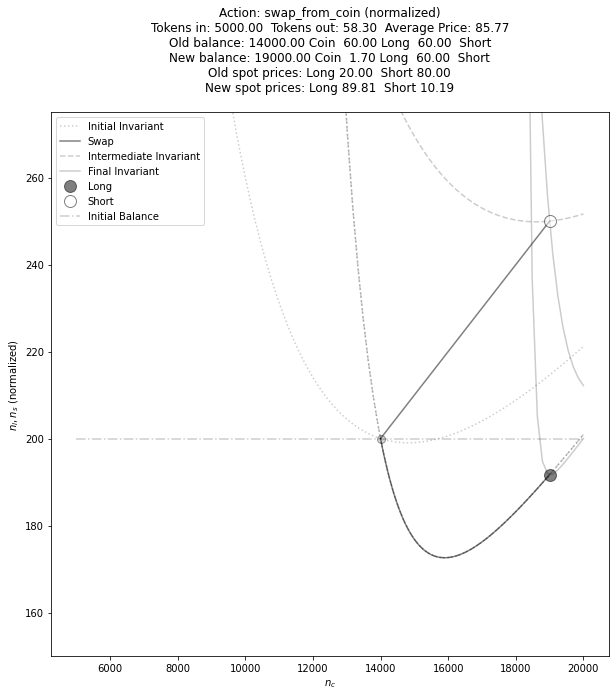

In [80]:
# Buying large amount of L tokens when asset is close to floor results in large impermanent loss
f = plt.figure(figsize=(10,10))
swap1_state = plot_action(
    set_amm_state(14000, 60, 60, 0.2, 100), 5000, action='swap_from_coin', 
    rebalance=True, coin_per_pair=100, sF=0.0, normalize_y=True
)
_ = plt.ylim((150, 275)) 
f.savefig(os.path.expanduser('~/Work/swap_20_140_60_norm.png'), bbox_inches='tight')

What this means: we can specify a maximum amount of impermanent loss we will accept on each swap, and change the ratio of coin to position tokens (via mint/redeem) to achieve this.  

Downside: will limit the amount of liquidity in position tokens e.g. as shown in $v=0.8$ plot.